## Load Images

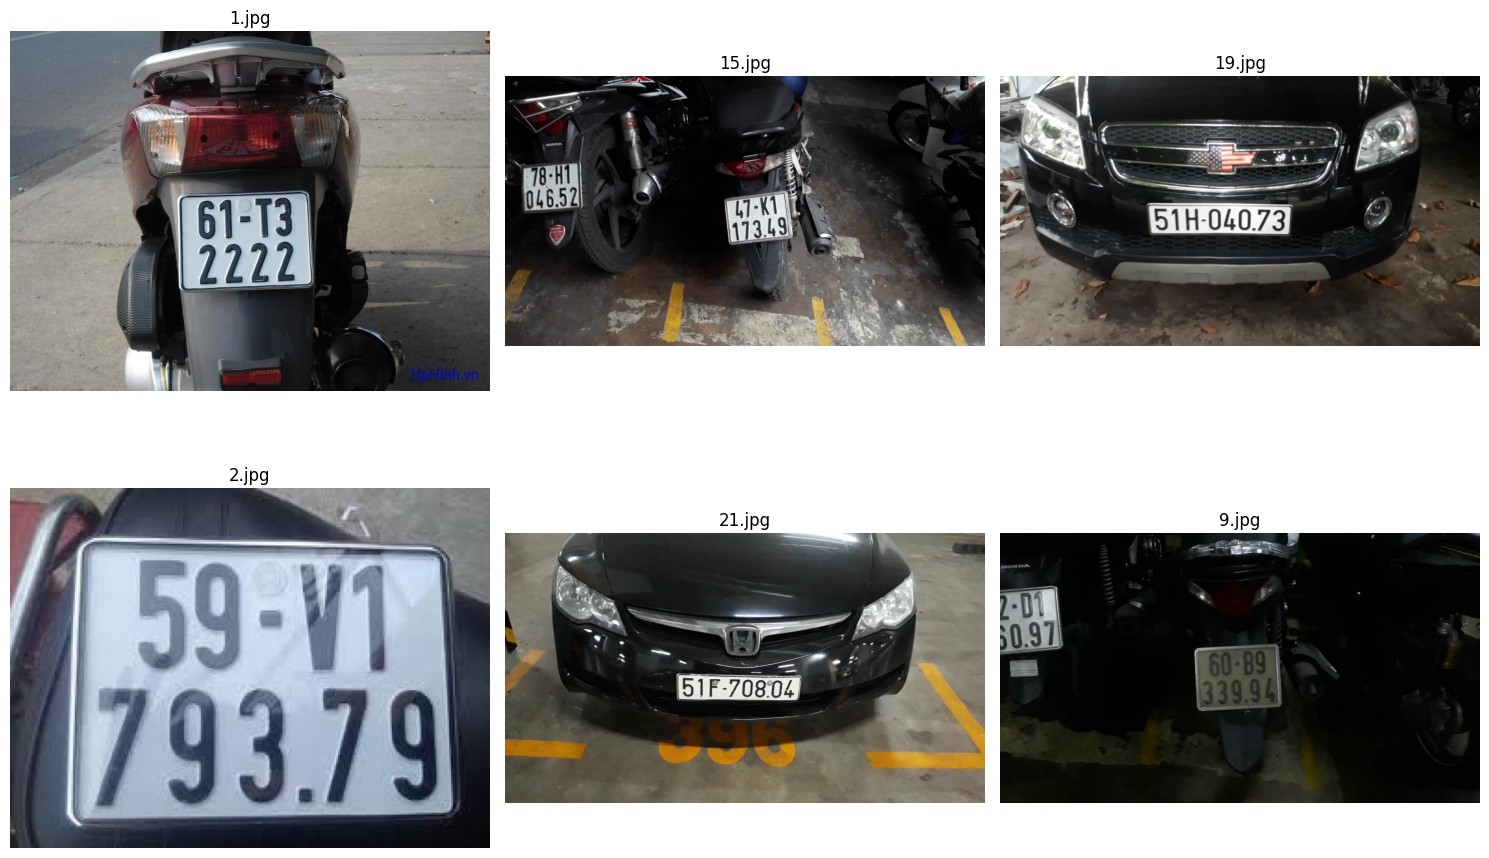

In [1]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
import math

# Path to the directory containing images
image_folder = 'image'

# Get a list of all image files (e.g., .jpg, .png) in the directory
image_files = glob.glob(os.path.join(image_folder, '*.[jp][pn]*g'))

# Check if any images were found
if not image_files:
    print("No images found in the directory.")
else:
    # Set up the number of rows and columns for the display grid
    num_images = len(image_files)
    cols = 3  # Number of columns you want (adjust as needed)
    rows = (num_images + cols - 1) // cols  # Calculate number of rows needed

    # Create a figure with subplots
    plt.figure(figsize=(15, 5 * rows))  # Adjust figure size as needed

    for i, image_path in enumerate(image_files):
        # Read and convert the image to RGB format
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Display the image in a subplot
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_rgb)
        plt.axis('off')  # Turn off axis labels
        plt.title(os.path.basename(image_path))  # Set the image filename as title

    plt.tight_layout()
    plt.show()


## Preprocess

In [2]:
print(image_files)

['image\\1.jpg', 'image\\15.jpg', 'image\\19.jpg', 'image\\2.jpg', 'image\\21.jpg', 'image\\9.jpg']


Hàm extractValue nhận vào một ảnh dưới định dạng màu BGR (định dạng mặc định của OpenCV) và trả về kênh độ sáng (cường độ sáng) của ảnh. Hàm này chuyển ảnh từ không gian màu BGR sang HSV và chỉ lấy kênh Value, đại diện cho độ sáng của từng điểm ảnh.

In [3]:
###################################################################################################
def extractValue(imgOriginal):
    # Lấy chiều cao, chiều rộng và số kênh màu của ảnh đầu vào
    height, width, numChannels = imgOriginal.shape
    # Khởi tạo một ảnh HSV trống có cùng kích thước với ảnh gốc
    imgHSV = np.zeros((height, width, 3), np.uint8)
    # Chuyển ảnh từ không gian màu BGR sang HSV
    imgHSV = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2HSV)
    # Tách ảnh HSV thành các kênh riêng lẻ: Hue, Saturation và Value
    imgHue, imgSaturation, imgValue = cv2.split(imgHSV)
    #màu sắc, độ bão hòa, giá trị cường độ sáng
    #Không chọn màu RBG vì vd ảnh màu đỏ sẽ còn lẫn các màu khác nữa nên khó xđ ra "một màu" 
    return imgValue
# end function

Hàm maximizeContrast này nhằm mục đích tăng độ tương phản của ảnh xám bằng cách sử dụng kỹ thuật biến đổi hình thái học (morphological transformations) như Top Hat và Black Hat. 

In [4]:
###################################################################################################
def maximizeContrast(imgGrayscale):
    # Lấy chiều cao và chiều rộng của ảnh xám
    height, width = imgGrayscale.shape
    # Khởi tạo ảnh Top Hat và Black Hat rỗng với kích thước giống ảnh gốc
    imgTopHat = np.zeros((height, width, 1), np.uint8)
    imgBlackHat = np.zeros((height, width, 1), np.uint8)
    # Tạo phần tử cấu trúc (kernel) để sử dụng trong các phép biến đổi hình thái học
    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)) #tạo bộ lọc kernel
    
    # Áp dụng phép biến đổi Top Hat để làm nổi bật chi tiết sáng trên nền tối
    imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement, iterations = 10) #nổi bật chi tiết sáng trong nền tối
    # cv2.imwrite("tophat.jpg",imgTopHat)
    
    # Áp dụng phép biến đổi Black Hat để làm nổi bật chi tiết tối trên nền sáng
    imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement, iterations = 10) #Nổi bật chi tiết tối trong nền sáng
    #cv2.imwrite("blackhat.jpg",imgBlackHat)

    # Cộng thêm chi tiết sáng từ ảnh Top Hat vào ảnh gốc
    imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat) 
    # Trừ đi chi tiết tối từ ảnh Black Hat để tạo ra ảnh có độ tương phản cao hơn
    imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)

    #cv2.imshow("imgGrayscalePlusTopHatMinusBlackHat",imgGrayscalePlusTopHatMinusBlackHat)
    #Kết quả cuối là ảnh đã tăng độ tương phản 
    return imgGrayscalePlusTopHatMinusBlackHat
# end function

In [5]:
# module level variables ##########################################################################
GAUSSIAN_SMOOTH_FILTER_SIZE = (5, 5) # Kích cỡ của bộ lọc Gauss (càng lớn thì ảnh càng mờ)
ADAPTIVE_THRESH_BLOCK_SIZE = 19 # Kích thước của ô cửa sổ để tính ngưỡng thích ứng
ADAPTIVE_THRESH_WEIGHT = 9 # Giá trị bù để điều chỉnh ngưỡng

###################################################################################################
def preprocess(imgOriginal):
    imgGrayscale = extractValue(imgOriginal)
    # imgGrayscale = cv2.cvtColor(imgOriginal,cv2.COLOR_BGR2GRAY) nên dùng hệ màu HSV
    # Trả về giá trị cường độ sáng ==> ảnh gray
    
    imgMaxContrastGrayscale = maximizeContrast(imgGrayscale) #để làm nổi bật biển số hơn, dễ tách khỏi nền
    #cv2.imwrite("imgGrayscalePlusTopHatMinusBlackHat.jpg",imgMaxContrastGrayscale)
    height, width = imgGrayscale.shape

    #Làm mịn ảnh bằng bộ lọc Gauss 5x5, sigma = 0
    imgBlurred = np.zeros((height, width, 1), np.uint8)
    imgBlurred = cv2.GaussianBlur(imgMaxContrastGrayscale, GAUSSIAN_SMOOTH_FILTER_SIZE, 0)
    #cv2.imwrite("gauss.jpg",imgBlurred)

    #Tạo ảnh nhị phân
    imgThresh = cv2.adaptiveThreshold(imgBlurred, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT)

    return imgGrayscale, imgThresh
#Trả về ảnh xám và ảnh nhị phân
# end function

### Image preprocess

In [6]:
img = cv2.imread("image\\1.jpg")
img = cv2.resize(img, dsize=(1920, 1080))

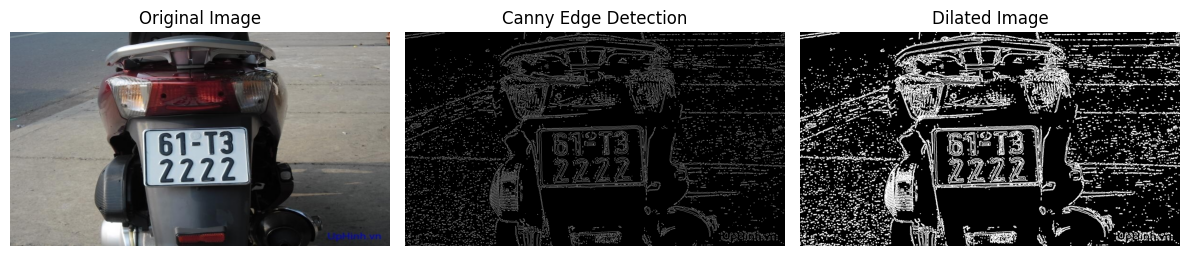

In [7]:
################ Image Preprocessing #################
imgGrayscaleplate, imgThreshplate = preprocess(img)

canny_image = cv2.Canny(imgThreshplate, 250, 255)  # Canny Edge
kernel = np.ones((3, 3), np.uint8)
dilated_image = cv2.dilate(canny_image, kernel, iterations=1)  # Dilation

# Hiển thị các ảnh trong một biểu đồ grid
plt.figure(figsize=(12, 8))

# Hiển thị ảnh gốc
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Hiển thị ảnh sau khi áp dụng Canny
plt.subplot(1, 3, 2)
plt.imshow(canny_image, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')

# Hiển thị ảnh sau khi áp dụng Dilation
plt.subplot(1, 3, 3)
plt.imshow(dilated_image, cmap='gray')
plt.title('Dilated Image')
plt.axis('off')

plt.tight_layout()
plt.show()
###########################################

## Contour

In [8]:
bk_img = img.copy()
n = 1

Min_char = 0.01
Max_char = 0.09

RESIZED_IMAGE_WIDTH = 30
RESIZED_IMAGE_HEIGHT = 60

###### Draw contour and filter out the license plate  #############
contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]  # Lấy 10 contours có diện tích lớn nhất

# cv2.drawContours(bk_img, contours, -1, (255, 0, 255), 3) # Vẽ tất cả các ctour trong hình lớn

screenCnt = []
for c in contours:
    peri = cv2.arcLength(c, True)  # Tính chu vi
    approx = cv2.approxPolyDP(c, 0.06 * peri, True)  # làm xấp xỉ đa giác, chỉ giữ contour có 4 cạnh
    [x, y, w, h] = cv2.boundingRect(approx.copy())
    ratio = w / h
    # cv2.putText(bk_img, str(len(approx.copy())), (x,y),cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 0), 3)
    # cv2.putText(bk_img, str(ratio), (x,y),cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 0), 3)
    if (len(approx) == 4):
        screenCnt.append(approx)
        cv2.putText(bk_img, str(len(approx.copy())), (x, y), cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 0), 3)

if screenCnt is None:
    detected = 0
    print("No plate detected")
else:
    detected = 1

# Load the trained SVM model
svm_model = cv2.ml.SVM_load("svm.xml")

if detected == 1:

    for screenCnt in screenCnt:
        cv2.drawContours(bk_img, [screenCnt], -1, (0, 255, 0), 3)  # Khoanh vùng biển số xe

        ############## Find the angle of the license plate #####################
        (x1, y1) = screenCnt[0, 0]
        (x2, y2) = screenCnt[1, 0]
        (x3, y3) = screenCnt[2, 0]
        (x4, y4) = screenCnt[3, 0]
        array = [[x1, y1], [x2, y2], [x3, y3], [x4, y4]]
        sorted_array = array.sort(reverse=True, key=lambda x: x[1])
        (x1, y1) = array[0]
        (x2, y2) = array[1]
        doi = abs(y1 - y2)
        ke = abs(x1 - x2)
        angle = math.atan(doi / ke) * (180.0 / math.pi)

        ####################################

        ########## Crop out the license plate and align it to the right angle ################

        mask = np.zeros(imgGrayscaleplate.shape, np.uint8)
        new_image = cv2.drawContours(mask, [screenCnt], 0, 255, -1, )
        # cv2.imshow("new_image",new_image)

        # Cropping
        (x, y) = np.where(mask == 255)
        (topx, topy) = (np.min(x), np.min(y))
        (bottomx, bottomy) = (np.max(x), np.max(y))

        roi = bk_img[topx:bottomx, topy:bottomy]
        imgThresh = imgThreshplate[topx:bottomx, topy:bottomy]
        ptPlateCenter = (bottomx - topx) / 2, (bottomy - topy) / 2

        if x1 < x2:
            rotationMatrix = cv2.getRotationMatrix2D(ptPlateCenter, -angle, 1.0)
        else:
            rotationMatrix = cv2.getRotationMatrix2D(ptPlateCenter, angle, 1.0)

        roi = cv2.warpAffine(roi, rotationMatrix, (bottomy - topy, bottomx - topx))
        imgThresh = cv2.warpAffine(imgThresh, rotationMatrix, (bottomy - topy, bottomx - topx))
        roi = cv2.resize(roi, (0, 0), fx=3, fy=3)
        imgThresh = cv2.resize(imgThresh, (0, 0), fx=3, fy=3)

        # cv2.imshow("imgThresh",imgThresh)
        # cv2.imshow("roi",roi)

        ##################################

        #################### Prepocessing and Character segmentation ####################
        kerel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        thre_mor = cv2.morphologyEx(imgThresh, cv2.MORPH_DILATE, kerel3)
        cont, hier = cv2.findContours(thre_mor, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        cv2.imshow(str(n + 20), thre_mor)
        cv2.drawContours(roi, cont, -1, (100, 255, 255), 2)  # Vẽ contour các kí tự trong biển số
        
        ##################### Filter out characters #################
        char_x_ind = {}
        char_x = []
        height, width, _ = roi.shape
        roiarea = height * width

        for ind, cnt in enumerate(cont):
            (x, y, w, h) = cv2.boundingRect(cont[ind])
            ratiochar = w / h
            char_area = w * h
            # cv2.putText(roi, str(char_area), (x, y+20),cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 0), 2)
            # cv2.putText(roi, str(ratiochar), (x, y+20),cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 0), 2)

            if (Min_char * roiarea < char_area < Max_char * roiarea) and (0.25 < ratiochar < 0.7):
                if x in char_x:  # Sử dụng để dù cho trùng x vẫn vẽ được
                    x = x + 1
                char_x.append(x)
                char_x_ind[x] = ind
                # cv2.putText(roi, str(char_area), (x, y+20),cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 0), 2)
                print(f"Ký tự lọc được tại vị trí: x={x}, y={y}, width={w}, height={h}, diện tích={char_area}, tỉ lệ={ratiochar}")
        
        ############ Character recognition ##########################

        char_x = sorted(char_x)
        strFinalString = ""
        first_line = ""
        second_line = ""
        
        for idx, i in enumerate(char_x):
            (x, y, w, h) = cv2.boundingRect(cont[char_x_ind[i]])
            cv2.rectangle(roi, (x, y), (x + w, y + h), (0, 255, 0), 2)

            imgROI = thre_mor[y:y + h, x:x + w]  # Crop the characters

            imgROIResized = cv2.resize(imgROI, (RESIZED_IMAGE_WIDTH, RESIZED_IMAGE_HEIGHT))  # resize image
            npaROIResized = imgROIResized.reshape(1, RESIZED_IMAGE_WIDTH * RESIZED_IMAGE_HEIGHT).astype(np.float32)
        
            _, npaResults = svm_model.predict(npaROIResized)
            result = int(npaResults[0][0])
            if result<=9: # Neu la so thi hien thi luon
                result = str(result)
            else: #Neu la chu thi chuyen bang ASCII
                result = chr(result)
                
            cv2.putText(roi, result, (x, y + 50), cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 0), 3)

            # Phân loại ký tự theo hàng trên hoặc dưới
            if y < height / 3:
                first_line += result
            else:
                second_line += result
            print("\n License Plate " + str(n) + " is: " + first_line + " - " + second_line + "\n")
        roi = cv2.resize(roi, None, fx=0.75, fy=0.75)
        cv2.imshow(str(n), cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))

        # cv2.putText(img, first_line + "-" + second_line ,(topy ,topx),cv2.FONT_HERSHEY_DUPLEX, 2, (0, 255, 255), 2)
        n = n + 1

bk_img = cv2.resize(img, None, fx=0.5, fy=0.5)
cv2.imshow('License plate', bk_img)

cv2.waitKey(0)

Ký tự lọc được tại vị trí: x=160, y=430, width=244, height=365, diện tích=89060, tỉ lệ=0.6684931506849315
Ký tự lọc được tại vị trí: x=484, y=424, width=238, height=371, diện tích=88298, tỉ lệ=0.6415094339622641
Ký tự lọc được tại vị trí: x=805, y=421, width=223, height=364, diện tích=81172, tỉ lệ=0.6126373626373627
Ký tự lọc được tại vị trí: x=1117, y=415, width=226, height=364, diện tích=82264, tỉ lệ=0.6208791208791209
Ký tự lọc được tại vị trí: x=178, y=34, width=214, height=355, diện tích=75970, tỉ lệ=0.6028169014084507
Ký tự lọc được tại vị trí: x=436, y=31, width=157, height=355, diện tích=55735, tỉ lệ=0.4422535211267606
Ký tự lọc được tại vị trí: x=862, y=22, width=211, height=367, diện tích=77437, tỉ lệ=0.5749318801089919
Ký tự lọc được tại vị trí: x=1099, y=19, width=214, height=355, diện tích=75970, tỉ lệ=0.6028169014084507

 License Plate 1 is:  - 2


 License Plate 1 is: 5 - 2


 License Plate 1 is: 51 - 2


 License Plate 1 is: 51 - 22


 License Plate 1 is: 51 - 222


 Li

-1

## Train SVM model

In [9]:
# import cv2
# import os
# import numpy as np
# import glob

# digit_w = 30
# digit_h = 60

# write_path="data/"

# def get_digit_data(path):#:, digit_list, label_list):

#     digit_list = []
#     label_list = []

#     for number in range(10):
#         i=0
#         for img_org_path in glob.iglob(path + str(number) + '/*.jpg'):
#             print(img_org_path)
#             img = cv2.imread(img_org_path, 0)
#             img = np.array(img)
#             img = img.reshape(-1, digit_h * digit_w)

#             print(img.shape)

#             digit_list.append(img)
#             label_list.append([int(number)])

#     for number in range(65, 91):
#         #number = chr(number)
#         print(number)
#         i=0
#         for img_org_path in glob.iglob(path + str(number) + '/*.jpg'):
#             print(img_org_path)
#             img = cv2.imread(img_org_path, 0)
#             img = np.array(img)
#             img = img.reshape(-1, digit_h * digit_w)

#             print(img.shape)

#             digit_list.append(img)
#             label_list.append([int(number)])

#     return  digit_list, label_list

# #lấy dữ liệu
# digit_path = "data/"
# digit_list, label_list = get_digit_data(digit_path)

# digit_list = np.array(digit_list, dtype=np.float32)
# digit_list = digit_list.reshape(-1, digit_h * digit_w)

# label_list = np.array(label_list)
# label_list = label_list.reshape(-1, 1)

# svm_model = cv2.ml.SVM_create()
# svm_model.setType(cv2.ml.SVM_C_SVC)
# svm_model.setKernel(cv2.ml.SVM_INTER)
# svm_model.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6))
# svm_model.train(digit_list, cv2.ml.ROW_SAMPLE, label_list)

# svm_model.save("svm.xml")